In [1]:
import os
import sys
# sys.path.append(os.path.join(os.getcwd(),'..','..','..'))
from ursse.hydra_harp_file_reader import HydraHarpFile
from ursse.LED_tests.data_analyzis import calc_Fano, get_time_window_hist, calc_Fano_from_counts_per_time_window
import numpy as np
import pandas as pd
import seaborn as sns
from ursse.data_processing import \
    get_event_delays, plot_arrival_time_hist, get_events_array, get_fanos, \
    plot_fanos_hist, process_file, read_event_delays, save_event_delays
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [15, 3.75]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import ursse.path_assistant as pa
shift = pa.PathAssistant('shift_02_28_2020')
from config_ursse import get_from_config
iota_period_sec = get_from_config("IOTA_revolution_period")
dt_sec = get_from_config("dt")
iota_period_au = iota_period_sec/dt_sec
import ursse_cpp.sync_motion_sim as sm
images_dir = os.path.join(get_from_config("URSSE_sync_motion_note_dir"),
                          "images")

In [2]:
df, n_revolutions = read_event_delays(shift.get_time_stamp_file_path('1el_002.ptu'))
t_delays = df.delay

In [3]:
gate = (61000, 66000)
dt=0.005 # sec

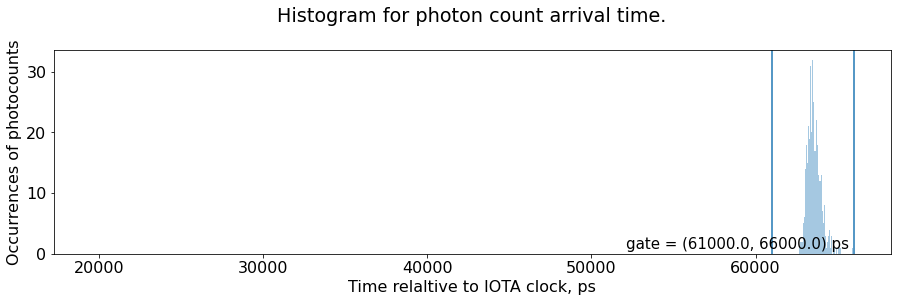

In [4]:
n = 500
i = 200
plot_arrival_time_hist(t_delays[i*n:(i+1)*n], gate=gate, bins=1000, yscale='linear')

In [5]:
from ursse.time_structure import get_bucket_gates, get_rate_in_gate_Hz,\
    reduce_df_to_one_gate, divide_df_into_time_bins, get_properties_in_time_bins
four_gates = get_bucket_gates(gate)
df0 = reduce_df_to_one_gate(df, gate).reset_index(drop=True)

In [6]:
delay_mean = df0['delay'].mean()
df0['delay'] = (df0['delay']-delay_mean)/1000

In [7]:
# import plotly.express as px
# fig = px.scatter(x=df0.loc[:1000, 'revolution'], y=df0.loc[:1000, 'delay'])
# fig.data[0].update(mode='markers+lines')
# fig.show()

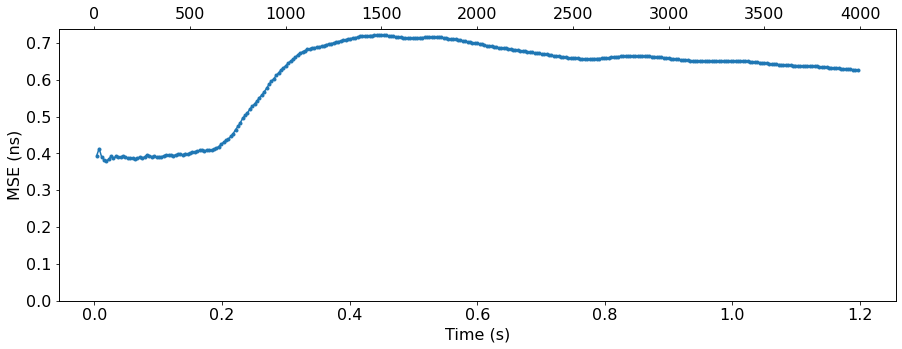

In [8]:
npers_list = 12.5*np.arange(1,320)
MSEs = []
T0s = [2372]
for first_fit_nper in npers_list:
    t0=T0s[-1]
#     first_fit_nper = 30
    df0_first_fit = df0[df0['revolution']<t0*first_fit_nper]
    from scipy.optimize import curve_fit
    def f(t, A, B, T):
        return A*np.cos(2*np.pi/T*t)+B*np.sin(2*np.pi/T*t)
    x = df0_first_fit['revolution'].values
    y = df0_first_fit['delay'].values
    p0 = (np.std(y), np.std(y), t0)
    popt, pcov = curve_fit(f, x, y, p0=p0)
    a, b, T0 = popt
    perr = np.sqrt(np.diag(pcov))
    x_fit = np.linspace(x[0],x[-1],10000)
    #x_fit_sec = x_fit*iota_period_sec
    y_fit = f(x_fit, a, b, T0)
    fit = f(df0_first_fit['revolution'], a, b, T0)
    MSE = np.sqrt(np.sum((fit-df0_first_fit['delay'])**2)/len(df0_first_fit.index))
    MSEs.append(MSE)
    T0s.append(T0)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(0.3e-3*npers_list, MSEs, '.-')
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_ylabel('MSE (ns)')
ax.set_xlabel('Time (s)')
ax1 = ax.twiny()
x1, x2 = ax.get_xlim()
ax1.set_xlim(x1/0.3e-3, x2/0.3e-3)
plt.show()

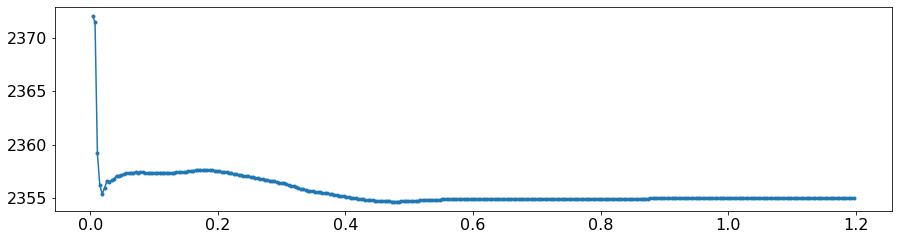

In [9]:
plt.plot(0.3e-3*npers_list, T0s[:-1], '.-')

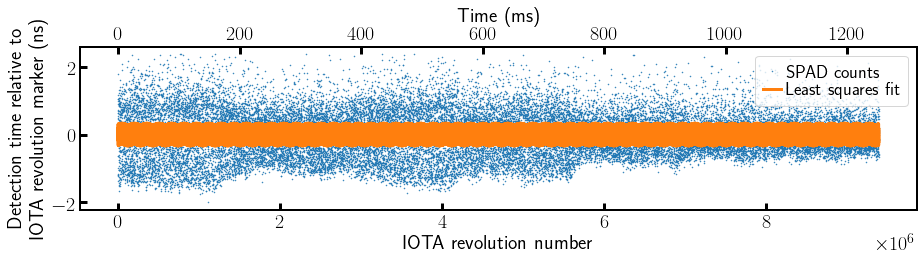

In [10]:
from ursse.path_assistant import get_plot_style_sheet
plt.style.use(get_plot_style_sheet("jinst"))
# plt.rcParams.update({'font.size': 15,
#                      'legend.fontsize':22,
#                      'errorbar.capsize': 3,
#                      'figure.figsize':(15,3)})
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(x, y, label='SPAD counts', marker='.', linestyle='None', markersize=1)
ax.plot(x_fit, y_fit, label='Least squares fit')
ax.set_ylabel('Detection time relative to\n IOTA revolution marker (ns)') #, fontsize=16)
ax.set_xlabel('IOTA revolution number')
ax1 = ax.twiny()
ax1.set_xlim(1000*iota_period_sec*np.asarray(ax.get_xlim()))
ax1.set_xlabel('Time (ms)')
#ax.set_xlim(0,0.0025)
ax.legend(loc=1)#, fontsize=12)
plt.show()